In [18]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torchsample
import psycopg2
import random
import re
import time
import csv
import copy

from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import models
from torchvision import transforms
from torchsample import transforms as ts_transforms

from matplotlib import pyplot as plt
from PIL import Image
from scipy.ndimage import imread
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor

from mpl_toolkits.mplot3d import Axes3D
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

## Necessary Classes for Testing Meteo Models

In [2]:
class meteo_NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(meteo_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [3]:
class resnet18_meteo(nn.Module):
    def __init__(self, resnet18, meteo_NN, num_classes):
        super(resnet18_meteo, self).__init__()
        
        # Respectively a torchvision resnet-18 and a 1-hidden layer NN
        self.resnet_CNN = resnet18
        self.meteo_net = meteo_NN
        
        # Sizes of the FC layers of both NN's
        self.len_fc_resnet = self.resnet_CNN.fc.in_features
        self.len_fc_meteo = self.meteo_net.fc2.out_features
        
        # Extract convolutional block out of predefined network
        self.modules=list(self.resnet_CNN.children())[:-1]
        self.resnet18_convblocks= nn.Sequential(*self.modules)
        
        self.fc = nn.Linear(self.len_fc_resnet + self.len_fc_meteo, num_classes)

    def forward(self, img_x, meteo_x):
        
        # Both should be flattened layers at end of networks
        img_x = self.resnet18_convblocks(img_x)
        meteo_x = self.meteo_net(meteo_x)

        # Flatten convolutional features
        img_x_flattened = img_x.view(img_x.size(0), -1)

        # Concat the outputs of CNN and meteo-NN in fully connected layer
        out = torch.cat([img_x_flattened, meteo_x], dim=1)

        out = self.fc(out)
        return out   

In [4]:
class simple_CNN(nn.Module):
    def __init__(self):
        super(simple_CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=32,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(32, 32, 3, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv3 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(32, 32, 3, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 16, 3, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )     
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Linear(576, 3)   # fully connected layer, output 3 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.dropout(x) 
        output = self.out(x)
        return output   # return x for visualization

## Helpers

### Certain/uncertain plot

### Most Uncertain Images

In [5]:
def plot_most_uncertain(outputs, corrects, predictions, loss, k=15):
    loss_differences = []

    for i, output in enumerate(outputs):
        if corrects[i] == 0:
            values, top2_idx = torch.topk(output, 2)
            top2 = output[top2_idx]
            difference = top2[0] - top2[1]
            loss_differences.append(difference.data[0])
        else:
            loss_differences.append(1000)

    loss_differences = np.asarray(loss_differences)
    indices = np.argsort(loss_differences)[:k]

    for idx in indices:
        print(test_filepaths[idx])
        plt.imshow(test_features[idx])
        plt.title('target: {} prediction: {} loss: {:.2f}'.format(test_targets[idx], predictions[idx], loss.data[idx]))
        plt.show()

### CM Matrix

In [6]:
 # Confusion matrix helper
def show_cm(targets, predictions):
    cm = confusion_matrix(y_target=targets, 
                      y_predicted=predictions, 
                      binary=False)

    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

### Dataset

In [7]:
class KNMIDataset(Dataset):
    def __init__(self, images, targets, filepaths, meteo=None, transforms=None):
    
        self.transforms = transforms
        self.images = images
        self.targets = targets
        self.filepaths = filepaths
        self.meteo = meteo

    def __getitem__(self, index):
        image = self.images[index]
        target = self.targets[index]
        filepath = self.filepaths[index]
        
        if self.transforms != None:
            image = self.transforms(image)
        if self.meteo != None:
            meteo = self.meteo[index]
            return (image, target, index, filepath, meteo)
        else:
            return (image, target, index, filepath)
        

    def __len__(self):
        return len(self.targets)

### Transforms

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(80),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(80),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Avg Accuracy

In [9]:
def get_average_accuracy(predictions, targets):
  
    # Lists for holding corrects
    no_fog_correct = 0
    light_fog_correct = 0
    dense_fog_correct = 0

    for pred, target in zip(predictions, targets):
        if pred == 0 and target == 0:
            no_fog_correct += 1
        elif pred == 1 and target == 1:
            light_fog_correct += 1
        elif pred == 2 and target == 2:
            dense_fog_correct += 1

    # Validation counts
    total = np.bincount(test_targets)
    no_fog_total = total[0]
    light_fog_total = total[1]
    dense_fog_total = total[2]

    # Accuracy per class
    acc_no_fog = no_fog_correct / no_fog_total
    acc_light = light_fog_correct / light_fog_total
    acc_dense = dense_fog_correct / dense_fog_total

    average_acc = (acc_no_fog + acc_light + acc_dense) / 3 * 100

    return average_acc

### Loss Curve Plotting

In [10]:
def plot_loss_curves(training_loss, validation_loss):
    """
    Plots loss curves after model training.
    
    :param training_loss: List with training loss for every epoch.
    :param validation_loss: List with validation loss for every epoch.
    """
    train_plot, = plt.plot(training_loss, label='Training')
    val_plot, = plt.plot(validation_loss, label='Validation')
    plt.title('Loss curves (training/validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(handles=[train_plot, val_plot])
    plt.show()

## Load Test Arrays (Non-Meteo)

In [12]:
test_features = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/test_refined/test_images.npy')
test_targets = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/test_refined/test_targets.npy')
test_filepaths = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/test_refined/test_filepaths.npy')

## Load Test Arrays (Meteo)

In [12]:
test_features = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/test_refined/MeteoTestInterpolation/test_images.npy')
test_targets = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/test_refined/MeteoTestInterpolation/test_targets.npy')
test_filepaths = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/test_refined/MeteoTestInterpolation/test_filepaths.npy')
test_meteo = np.load('/Volumes/TIMPP/UnusedKNMI/numpyfiles/test_refined/MeteoTestInterpolation/test_meteo.npy')

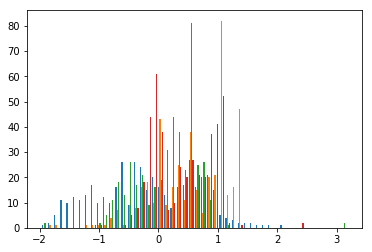

In [17]:
plt.hist(test_meteo, bins=50)
plt.show()

## Function That Loads Models to Test

In [13]:
def load_model(filepath):
    '''
    Loads a trained model.
    
    :param filepath: Path to the trained model.
    '''
    loaded_model = torch.load(filepath, map_location=lambda storage, loc: storage)

    
    return loaded_model

### Test Dataset and Dataloader

In [149]:
test_dataset = KNMIDataset(test_features, test_targets, test_filepaths, transforms=data_transforms['validation'])
test_dataloader = DataLoader(dataset=test_dataset, batch_size=len(test_features),shuffle=False)

## Load Model of Interest

Best overall accuracy: 98.81%.
Best average accuracy: 88.95%. At epoch 28
Best f1-macro: 0.745. At epoch 42
Confusion Matrix best f1-macro validation:


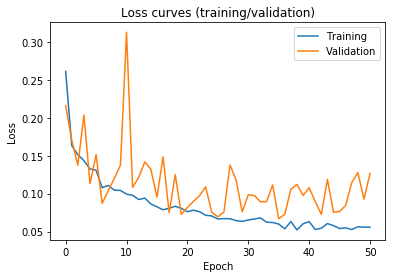

In [68]:
TRAINED_MODELS_DIR = '/Volumes/TIMPP/TrainedModels'

checkpoint = load_model(TRAINED_MODELS_DIR + '/Experiment1/new_images/highway/tune2/completed_tuner2.pth.tar')
# checkpoint = load_model(TRAINED_MODELS_DIR + '/Experiment1/new_images/highway+knmi2/tune4/completed_tuner2.pth.tar')
# checkpoint = load_model(TRAINED_MODELS_DIR + '/Experiment1/new_images/knmi/tune4/completed_tuner4.pth.tar')

model_f1 = checkpoint['best_model_f1']
model_avg = checkpoint['best_model_avg']

# Get stats
best_epoch_f1, best_epoch_avg = checkpoint['best_epoch_f1'], checkpoint['best_epoch_avg']
best_f1_value, best_avg_value = checkpoint['best_f1'], checkpoint['best_avg_acc']
print('Best overall accuracy: {:.2f}%.'.format(checkpoint['best_accuracy']))
print('Best average accuracy: {:.2f}%. At epoch {}'.format(best_avg_value, best_epoch_avg))
print('Best f1-macro: {:.3f}. At epoch {}'.format(best_f1_value, best_epoch_f1))

try:
    print('Confusion Matrix best f1-macro validation:')
    show_cm(checkpoint['f1_val_targets'], checkpoint['f1_val_preds'])

    print('Confusion Matrix best avg accuracy validation:')
    show_cm(checkpoint['avg_val_targets'], checkpoint['avg_val_preds'])
except:
    pass

train_loss = checkpoint['train_loss']
validation_loss = checkpoint['validation_loss']
plot_loss_curves(train_loss, validation_loss)

## Test Model Function

### Test the Model

Confusion matrix test set average accuracy:
/Volumes/TIMKNMI/KNMIPictures/RWS/A16/HM240/ID12262/201712/A16-HM240-ID12262_20171222_0800.jpg


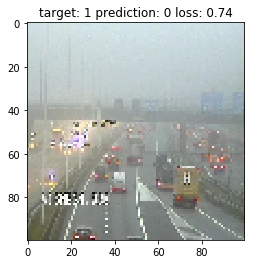

/Volumes/TIMKNMI/KNMIPictures/RWS/A16/HM209/ID71700/201712/A16-HM209-ID71700_20171222_1020.jpg


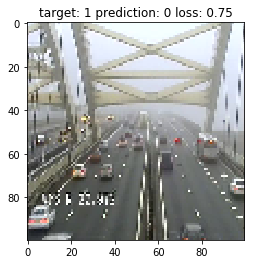

/Volumes/TIMKNMI/KNMIPictures/RWS/A15/HM793/ID12043/201712/A15-HM793-ID12043_20171201_0830.jpg


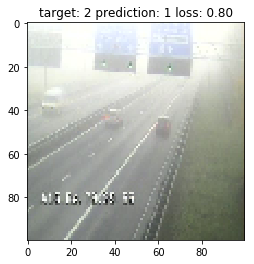

/Volumes/TIMKNMI/KNMIPictures/RWS/A28/HM2000/ID13516/201712/A28-HM2000-ID13516_20171202_0720.jpg


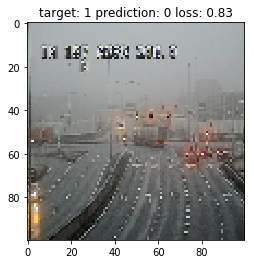

/Volumes/TIMKNMI/KNMIPictures/RWS/A27/HM577/ID10979/201712/A27-HM577-ID10979_20171202_0900.jpg


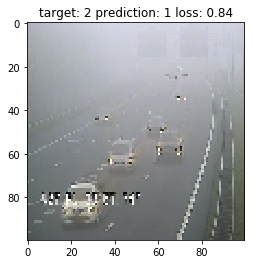

/Volumes/TIMKNMI/KNMIPictures/RWS/A27/HM577/ID10979/201712/A27-HM577-ID10979_20171202_0900.jpg


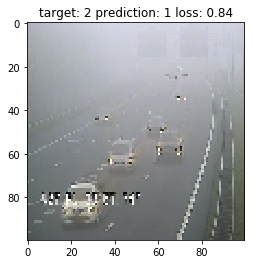

/Volumes/TIMKNMI/KNMIPictures/RWS/A2/HM784/ID10917/201712/A2-HM784-ID10917_20171202_0820.jpg


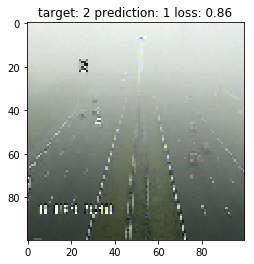

/Volumes/TIMKNMI/KNMIPictures/RWS/A15/HM786/ID12041/201712/A15-HM786-ID12041_20171201_0900.jpg


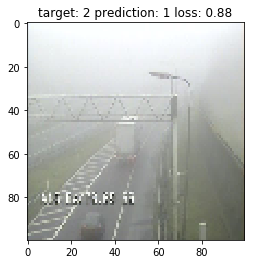

/Volumes/TIMKNMI/KNMIPictures/RWS/A50/HM1835/ID11509/201712/A50-HM1835-ID11509_20171201_0750.jpg


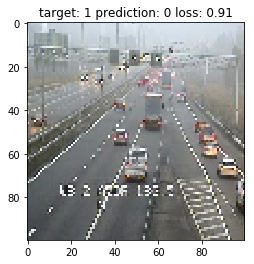

/Volumes/TIMKNMI/KNMIPictures/RWS/A15/HM242/ID13550/201712/A15-HM242-ID13550_20171221_1110.jpg


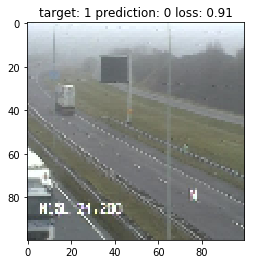

/Volumes/TIMKNMI/KNMIPictures/RWS/A2/HM748/ID10907/201711/A2-HM748-ID10907_20171102_1020.jpg


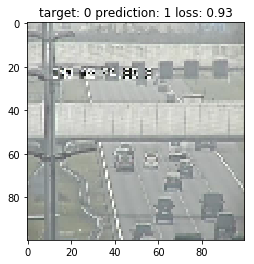

/Volumes/TIMKNMI/KNMIPictures/RWS/A50/HM1858/ID11642/201712/A50-HM1858-ID11642_20171202_1530.jpg


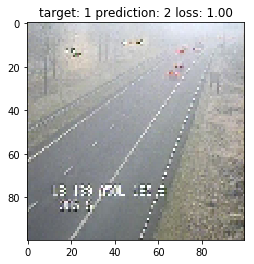

/Volumes/TIMKNMI/KNMIPictures/RWS/A50/HM1847/ID11513/201712/A50-HM1847-ID11513_20171202_1330.jpg


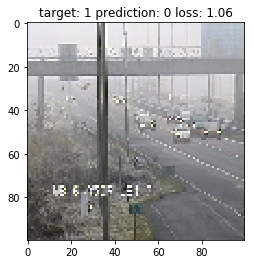

/Volumes/TIMKNMI/KNMIPictures/RWS/A27/HM652/ID10968/201712/A27-HM652-ID10968_20171202_0850.jpg


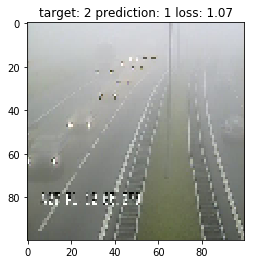

/Volumes/TIMKNMI/KNMIPictures/RWS/A2/HM790/ID10918/201712/A2-HM790-ID10918_20171202_0930.jpg


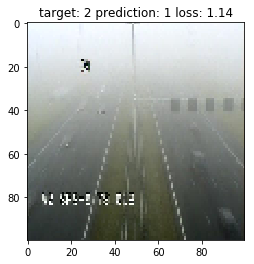

/Volumes/TIMKNMI/KNMIPictures/RWS/A4/HM449/ID12003/201712/A4-HM449-ID12003_20171222_0830.jpg


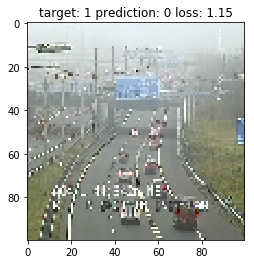

/Volumes/TIMKNMI/KNMIPictures/RWS/A4/HM447/ID12090/201712/A4-HM447-ID12090_20171202_0810.jpg


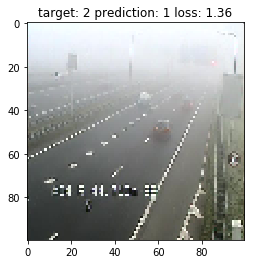

/Volumes/TIMKNMI/KNMIPictures/RWS/A1/HM43/ID13972/201712/A1-HM43-ID13972_20171222_1510.jpg


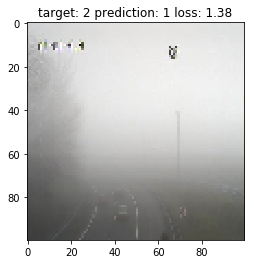

/Volumes/TIMKNMI/KNMIPictures/RWS/A28/HM2000/ID13516/201712/A28-HM2000-ID13516_20171202_0820.jpg


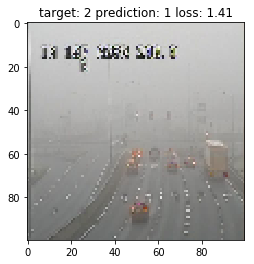

/Volumes/TIMKNMI/KNMIPictures/RWS/A1/HM61/ID12961/201712/A1-HM61-ID12961_20171222_1500.jpg


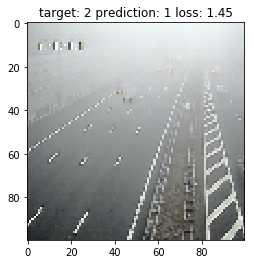

Test stats
Overall accuracy: 92.04%
Average accuracy: 92.04%
f1-macro:0.920
f1-micro: 0.920


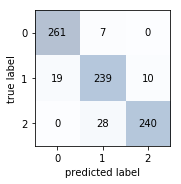

In [172]:
import heapq

def test_model(model, dataloader):
    """
    Tests a specified model on all the manually labeled highway camera
    images. 
    
    :param model: Trained model to evaluate
    :param test_features: All test features as tensor
    :param test_targets: All test labels as tensor
    """
    
    test_images, test_targets, idx, test_filepaths = next(iter(dataloader))
    
    # Loss criterion
    criterion = nn.CrossEntropyLoss(reduce=False)
    
    # Wrap tensors
    features = Variable(test_images)
    targets = Variable(test_targets)
#     meteo = Variable(meteo.type(torch.FloatTensor))
    total = len(targets)
    
    # Feed test features into model
    outputs = model(features)
    
    # Loss and optimization
    loss = criterion(outputs, targets)
    
    # Get test predictions and number of correct predictions
    _, predictions = torch.max(outputs.data, 1) 
    correct = torch.sum(predictions == targets.data)  
    corrects = predictions == targets.data
    
    plot_most_uncertain(outputs, corrects, predictions, loss, k=20)
    
#     for i, cor in enumerate(corrects):
#         if predictions[i] == 1 and cor == 0:
#             print(test_filepaths[i])
#             print(test_targets[i])
#             img = test_features[i]
#             plt.imshow(img)
#             plt.show()
             
    image_indices = list(range(0, total))
#     plot_images(loss, image_indices, test_filepaths, targets, predictions, phase='test', amount=15)
    
    
    test_accuracy = correct / total * 100
    avg_accuracy = get_average_accuracy(targets.data.numpy(), predictions.numpy())

    f1_macro = f1_score(targets.data.numpy(), predictions.numpy(), average='macro')
    f1_micro = f1_score(targets.data.numpy(), predictions.numpy(), average='micro')
    
    print('Test stats\nOverall accuracy: {:.2f}%\n'
          'Average accuracy: {:.2f}%\nf1-macro:' 
          '{:.3f}\nf1-micro: {:.3f}'.format(test_accuracy, avg_accuracy,
                                            f1_macro, f1_micro))
    
    show_cm(list(targets.data), list(predictions))

# print('Confusion matrix test set f1 macro:')
# test_model(model_f1, test_dataloader)
print('Confusion matrix test set average accuracy:')
test_model(model_avg, test_dataloader)

In [93]:
def plot_images(loss, image_index, filepaths, targets, predictions, phase, amount=15):
    """
    Use to plot images that the model is most certain about and which it was most uncertain about.
    
    :param loss: Tensor that has size of batch containing loss
    :param filepaths: List with filepaths that point to where batch images are located
    :param amount: Amount of images to show. Default: 1
    """
    
    def loop_plot(indices, targets, predictions, filepaths, losses, phase, amount):    
        fig=plt.figure(figsize=(20, amount))
        columns = 5
        rows = amount / 5
        
        # Determine phase and get image np array
        if phase == 'train':
            image_array = X_train
        elif phase == 'validation':
            image_array = X_validation
        else:
            image_array = test_features

        # Loop over the data and plot 'amount' of images
        for i, (index, target, prediction, loss) in enumerate(zip(indices, targets, predictions, losses)):
            img = image_array[index]
            fig.add_subplot(rows, columns, i + 1)
            plt.title('target: {}, prediction: {} loss: {:.2f}'.format(target, prediction, loss))
            plt.imshow(img)
      
        plt.show()
    
    def get_k_and_plot(loss, amount, targets, image_index, filepaths, predictions, phase, largest=True):
        # Get all relevant data
        values, indices = torch.topk(loss, amount, largest=largest)
        targets = [targets[i].data[0] for i in list(indices.data.cpu().numpy().reshape((1, -1))[0])]
        images_idx = [image_index[i] for i in list(indices.data.cpu().numpy().reshape((1, -1))[0])]
        filepaths = [filepaths[i] for i in list(indices.data.cpu().numpy().reshape((1, -1))[0])]
        predictions = [predictions[i] for i in list(indices.data.cpu().numpy().reshape((1, -1))[0])]
        loss = [loss.data[i] for i in list(indices.data.cpu().numpy().reshape((1, -1))[0])]

        # Show images (uncertain/certain)
        loop_plot(images_idx, targets, predictions, filepaths, loss, phase, amount)

    print('Top {} most uncertain images'.format(amount))
    get_k_and_plot(loss, amount, targets, image_index, filepaths, predictions, phase, largest=True)

    
    print('Top {} most certain images'.format(amount))
    get_k_and_plot(loss, amount, targets, image_index, filepaths, predictions, phase, largest=False)